# "Airbnb Recommends" Revenue Optimization Experiment

Arlyss Gease Data-201 Capstone 1

## Introduction

This document outlines an experiment aimed to increase Airbnb company revenues by nudging guests towards underutilized high-revenue potential listings by associating an "Airbnb Recommends" icon with such listings. 

This document includes:

   - Details on the hypothesis and experimental design
   - An evaluation plan for the experiment
   - Preliminary analysis of a proposed test market: San Francisco
   

## Hypothesis and Experimental Design

Our most basic hypothesis is that Airbnb can improve revenues by nudging users away from overutilized low-price properties towards underutilized moderate-to-high priced properties. More specifically, we propose to test the following hypothesis:

<b>Hypothesis:</b> Airbnb can increase revenue by deploying an "Airbnb Recommends" icon for display on underutilized high satisfaction moderate-to-high priced listings. 

Given that Airbnb company revenue is proportionate to listing revenue, and listing revenue is driven by price and quantity of stays, directing stays towards higher-priced properties will, other things equal, increase revenue.

We propose to test this experiment by deploying the "Airbnb Recommends" label in one major US market: San Francisco. We have conducted a preliminary analysis of the market based on data scraped from the Airbnb website. As historic bookings data is not available, we use reviews as a proxy for stays.

As can be seen in <b>Figure 1</b>, low-priced listings generate an outsized number of monthly reviews.

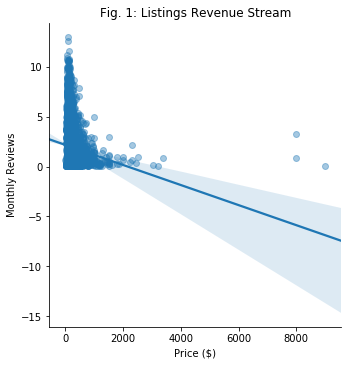

Excluding price outliers shows a heavy concentration of reviews in listings with a daily price of less than $200 over the past 12 months (<b>Figure 2</b>).

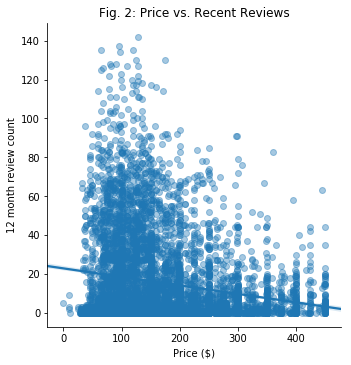

To verify that this skew is not just due to more avilailability in lower-priced listings, we use the ratio of ((reviews from the last 12 months) / (availability in the next 12 months)) as a proxy for utilization (considering only properties with estimated utilization between 0 and 1). <b>Figure 3</b> shows lower utilization of higher-priced properties.

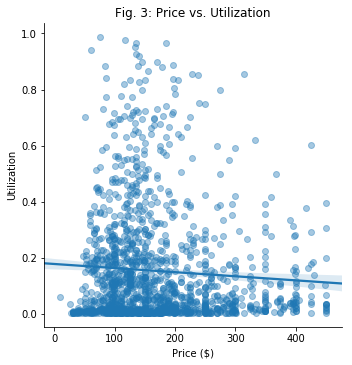

We focus our proposed experiment on this population.

<b>Qualified Population:</b> A listing qualifies for the test if it meets the following three criteria.

- Daily price above $200
- Satisfaction above 90%
- Estimated utilization below 50%

<b>Trial Size and Control:</b>


## Experiment Evaluation

## Appendix: Supporting Analyses

In [159]:
%matplotlib inline
import pandas as pd
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from datetime import date

In [109]:
calendar = pd.read_csv('calendar (sf).csv')
listings = pd.read_csv('listings (sf).csv')
reviews  = pd.read_csv('reviews (sf).csv')

Our goal is to optimize revenue, which is driven by listing price and the number of reviews over time. First, we create a data frame to review the price and monthly reviews data from the listings table.

In [3]:
df = pd.DataFrame()
df['listing_id'] = listings['id']
df['reviews_monthly'] = listings['reviews_per_month']
df['price ($)'] = listings['price'].apply(lambda x: float(''.join(list(filter(str.isdigit, str(x))))))/100

As expected, price and monthly reviews are inversely correlated, as shown here:

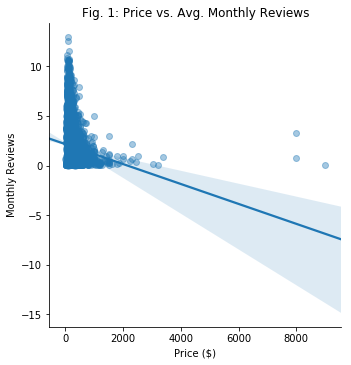

In [197]:
#Fig 1
scatter = sns.lmplot(y='reviews_monthly', x='price ($)', data=df, 
               fit_reg=True, scatter_kws={'alpha':0.4})
scatter.set_ylabels("Monthly Reviews")
scatter.set_xlabels("Price ($)")
plt.title('Fig. 1: Price vs. Avg. Monthly Reviews')
plt.show()

To improve our analysis, we throw out high-price outliers, and count the number of reviews received in the last 12 months to ensure review volumes are up to date.

In [35]:
#add a columns to the review table to indicate year, month, and whether the review is our 12 month range
reviews['review_year'] = 0
for i in reviews.index:
    reviews.at[i,'review_year'] = int(reviews.at[i,'review_date'][-2:])
reviews['review_month'] = 0
for i in reviews.index:
    reviews.at[i,'review_month'] = int(reviews.at[i,'review_date'][:2].replace('/', ''))
reviews['12_mo_range'] = False
for i in reviews.index:
    if reviews.at[i,'review_year'] == 18 and reviews.at[i,'review_month']<10:
        reviews.at[i,'12_mo_range'] = True
    elif reviews.at[i,'review_year'] == 17 and reviews.at[i,'review_month']>9:
        reviews.at[i,'12_mo_range'] = True  

In [76]:
#add the count of reviews in the last 12 months to df
reviews_oct17_sept18 = reviews[reviews['12_mo_range']][['listing_id','id']].groupby('listing_id').aggregate('count')['id']
reviews_oct17_sept18
df['reviews_12_mo'] = 0
for i in reviews_oct17_sept18.index:
        df.at[df[df['listing_id']==i].index.tolist()[0],'reviews_12_mo'] = reviews_oct17_sept18[i]

In [99]:
#add a column to df indicating whether price is an outlier
q1 = df['price ($)'].quantile([.25]).tolist()[0]
q3 = df['price ($)'].quantile([.75]).tolist()[0]
outlier = q3 + (q3 - q1)*1.5
outlier
df['outlier'] = False
for i in df.index:
    if df.at[i,'price ($)'] > outlier:
        df.at[i,'outlier'] = True

Now we can recreate the Price x Reviews plot using excluding price outliers and using our count of reviews in the last year

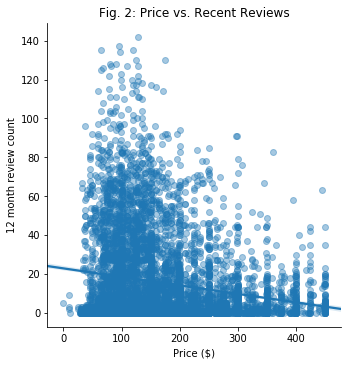

In [196]:
#Fig 2
scatter = sns.lmplot(y='reviews_12_mo', x='price ($)', data=df.where(df['outlier'] == False), 
               fit_reg=True, scatter_kws={'alpha':0.4})
scatter.set_ylabels("12 month review count")
scatter.set_xlabels("Price ($)")
plt.title('Fig. 2: Price vs. Recent Reviews')
plt.show()

Next we calculate the number of days each listing has available in 2019 according to the Calendar table.

In [135]:
calendar['year'] = 0
for i in calendar.index:
    calendar.at[i,'year'] = int(calendar.at[i,'calendar_date'][-2:])
    
calendar_2019 = calendar[calendar['year']==19].copy()

In [138]:
calendar_2019['availa_bool'] = False
for i in calendar_2019.index:
    calendar_2019.at[i,'availa_bool'] = (calendar_2019.at[i,'available'] == 't')

In [142]:
available_2019 = calendar_2019[calendar_2019['availa_bool']][['listing_id','availa_bool']].groupby('listing_id').aggregate('count')['availa_bool']

And add estimated utilization to the analysis table

In [188]:
df['availability'] = 0
for i in available_2019.index:
        df.at[df[df['listing_id']==i].index.tolist()[0],'availability'] = available_2019[i]
df['utilization'] = df['reviews_12_mo'] / df['availability']
df['0to1'] = False
for i in df.index:
    df.at[i,'0to1'] = not( math.isnan(df.at[i,'utilization']) or math.isinf(df.at[i,'utilization']) or (df.at[i,'utilization']==0) or (df.at[i,'utilization']>=1))

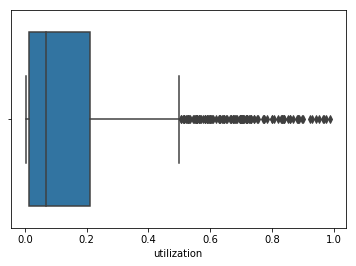

In [193]:
sns.boxplot(df[df['0to1']].where(df['outlier'] == False)['utilization'])

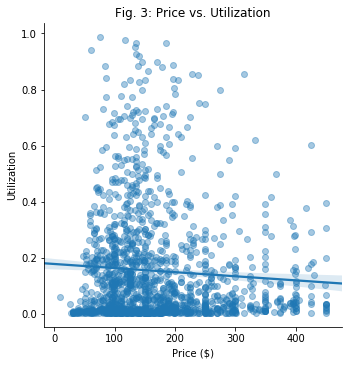

In [198]:
#Fig 3
scatter = sns.lmplot(y='utilization', x='price ($)', data=df.where(df['outlier'] == False).where(df['0to1'] == True), 
               fit_reg=True, scatter_kws={'alpha':0.4})
scatter.set_ylabels("Utilization")
scatter.set_xlabels("Price ($)")
plt.title('Fig. 3: Price vs. Utilization')
plt.show()

## Old stuff (to remove)


To prepare for the experiement, we should review the Airbnb data we have available to consider how the experiment should be implemented. Specifically, I recommend we:
- come up with a measure of calendar availablility based on the calendar table
- come up with an indicator of positive/negative sentiment based on the review table
- determine which columns in the listings table are ammenable to quantitative measures that we can use to segment different types of listings


In [11]:
#checking whether hosts have multiple 'host_since' dates (for each listing) 
listings[['host_id','host_since']].groupby('host_id').aggregate('count').head()

,host_since
host_id,
46,1
470,1
1169,1
4921,2
6267,1


In [12]:
#creating my analysis df
listing_analysis = pd.DataFrame()
listing_analysis['listing_id'] = listings['id']
listing_analysis['listed_since'] = listings['host_since']
listing_analysis['review_count'] = listings['number_of_reviews']
listing_analysis['review_score'] = listings['review_scores_rating']
listing_analysis['monthly_reviews'] = listings['reviews_per_month']

#get prices, converting to floats
listing_analysis['price ($)'] = listings['price'].apply(lambda x: float(''.join(list(filter(str.isdigit, str(x))))))/100

#save old code that creates errors to discuss/push to github
#iterrows returns a 'generator'
#try out the dummy variable method from pandas

#create dummy variables for response time values 
listing_analysis['responds within an hour'] = 0
for i in listing_analysis.index:
    if listings.at[i,'host_response_time'] == 'within an hour':
        listing_analysis.at[i,'responds within an hour'] = 1
    else:
        listing_analysis.at[i,'responds within an hour'] = 0
listing_analysis['responds within a few hours'] = 0
for i in listing_analysis.index:
    if listings.at[i,'host_response_time'] == 'within a few hours':
        listing_analysis.at[i,'responds within a few hours'] = 1
    else:
        listing_analysis.at[i,'responds within a few hours'] = 0
listing_analysis['responds within a day'] = 0
for i in listing_analysis.index:
    if listings.at[i,'host_response_time'] == 'within a day':
        listing_analysis.at[i,'responds within a day'] = 1
    else:
        listing_analysis.at[i,'responds within a day'] = 0
listing_analysis['responds slowly or no data'] = 0
for i in listing_analysis.index:
    if max(listing_analysis.at[i,'responds within an hour'],listing_analysis.at[i,'responds within a few hours'],listing_analysis.at[i,'responds within a day']) == 0:
        listing_analysis.at[i,'responds slowly or no data'] = 1
    else:
        listing_analysis.at[i,'responds slowly or no data'] = 0

        
        
listing_analysis.head()


,listing_id,listed_since,review_count,review_score,monthly_reviews,price ($),responds within an hour,responds within a few hours,responds within a day,responds slowly or no data
0,958,2008-07-31,160,97.0,1.43,170.0,1,0,0,0
1,5858,2009-03-02,112,98.0,0.98,235.0,0,0,0,1
2,7918,2009-06-17,17,85.0,0.15,65.0,0,1,0,0
3,8142,2009-06-17,8,93.0,0.16,65.0,0,1,0,0
4,8339,2009-07-02,27,97.0,0.25,785.0,0,0,0,1


In [116]:
#look at scores plot
sns.boxplot(listing_analysis['review_score']) 
plt.title('Scores Plot')
plt.show()

#call method on boxplot to say, give me the ones above the 3rd quartile
#for airbnb approved, can focus on folks over 90, etc.
#predictive analytics: important concepts for how data is scaled (normalize all variables), normalize after you throw out outliers

NameError: name 'listing_analysis' is not defined